<a href="https://colab.research.google.com/github/ealeongomez/Deep-Learning/blob/master/RBF_RandomRegresion_WindSpeed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Basic packages
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Machine learning packages 
from sklearn.model_selection import train_test_split

# Deep learning packages 
import tensorflow as tf
from tensorflow import keras

tf.__version__


'2.4.1'

In [2]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  '''
    INPUT 
      dataset: time serie
      start_index: index of initial 
      end_index: index of end
      history_size: size of windows
      target_size
    OUTPUT:
      X:
      y: 
  '''

  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])

  X = np.array(data)
  y = np.array(labels)

  return X, y 

In [3]:
# Import data 
csv_path  = 'https://www.data.qld.gov.au/dataset/fc8d4550-1d2f-4e56-a2db-7b5f11b903ed/resource/16fc598d-6dae-4c5e-a69b-580f698530aa/fs_download/deceptionbayaq2016.csv'
df = pd.read_csv(csv_path)

# Print dataset
df.head()

,Date,Time,Wind Direction (degTN),Wind Speed (m/s),Wind Sigma Theta (deg),Wind Speed Std Dev (m/s),Ozone (ppm),Nitrogen Oxide (ppm),Nitrogen Dioxide (ppm),Nitrogen Oxides (ppm)
0,01/01/2016,00:00,186.0,2.1,16.9,0.7,NaN,NaN,NaN,NaN
1,01/01/2016,01:00,207.0,1.8,15.2,0.5,0.013,0.0,0.004,0.004
2,01/01/2016,02:00,203.0,2.2,12.9,0.7,0.012,0.0,0.004,0.004
3,01/01/2016,03:00,211.0,2.7,11.5,0.8,0.014,0.0,0.002,0.002
4,01/01/2016,04:00,221.0,1.8,13.4,0.6,0.013,0.0,0.003,0.003


In [4]:
uni_data = df['Wind Speed (m/s)']                                  # Seleccionar el conjunto de los datos a predecir 
uni_data = uni_data.fillna(df['Wind Speed (m/s)'].mean())           # Remover los valores nan por la media de los datos
uni_data.index = df['Date']                                        # Seleccionar las fechas de las velocidades del viento

uni_data.head()                                                    # Imprimir los datos 

Date
01/01/2016    2.1
01/01/2016    1.8
01/01/2016    2.2
01/01/2016    2.7
01/01/2016    1.8
Name: Wind Speed (m/s), dtype: float64

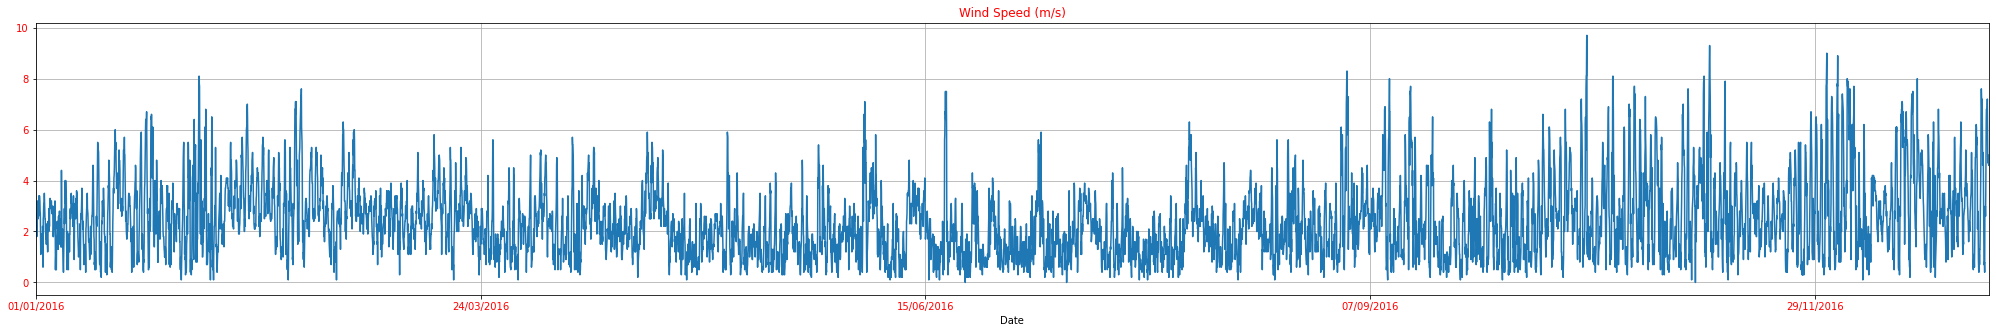

In [5]:
# Ploter el conjunto de datos 
plt.figure(figsize=(35,5))
uni_data.plot(subplots=True)
plt.xlim(0,len(df))
plt.xticks(c='r')
plt.yticks(c='r')
plt.title('Wind Speed (m/s)', c='r')
plt.grid(True)

In [6]:
timeSerie = uni_data.values
timeSerie = (timeSerie-min(timeSerie))/(max(timeSerie)-min(timeSerie))  # Normalización de los datos 

time = np.arange(0, len(timeSerie),1)

X__, y__ = univariate_data(timeSerie, 0, None, 10, 0)

X_, X_test, y_, y_test = train_test_split(X__, y__, test_size=0.20, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=0.20, random_state=42)

X_train.shape, X_valid.shape, X_test.shape


((5615, 10, 1), (1404, 10, 1), (1755, 10, 1))

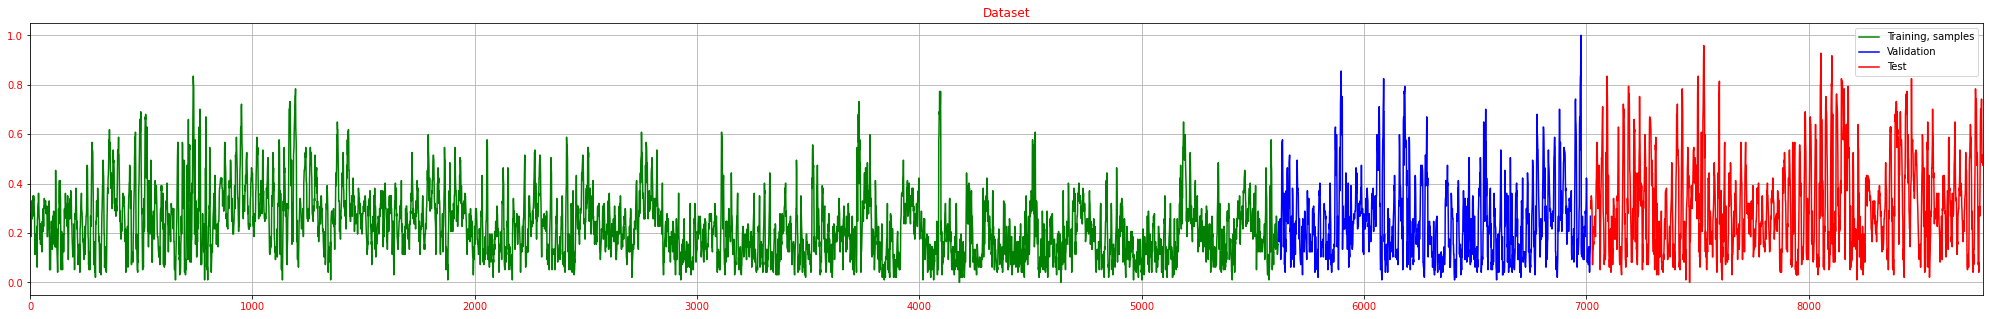

In [7]:
# Ploter el conjunto de datos 
plt.figure(figsize=(35,5))
plt.plot(time[0:X_train.shape[0]], timeSerie[0:X_train.shape[0]], 'g', label= 'Training, samples')
plt.plot(time[X_train.shape[0]:X_train.shape[0]+X_valid.shape[0]], timeSerie[X_train.shape[0]:X_train.shape[0]+X_valid.shape[0]], 'b', label= 'Validation')
plt.plot(time[X_train.shape[0]+X_valid.shape[0]:], timeSerie[X_train.shape[0]+X_valid.shape[0]:], 'r', label= 'Test')
plt.title('Dataset', c='r')
plt.xticks(c='r')
plt.yticks(c='r')
plt.xlim(0,timeSerie.shape[0])
plt.legend()
plt.grid(True)
plt.show()

In [8]:
l1 = 1e-3
l2 = 1e-3

input = tf.keras.layers.Input(shape=(X_train.shape[1]), name='Input')

hidden = tf.keras.layers.experimental.RandomFourierFeatures(output_dim=500,
                                                            scale=2,
                                                            kernel_initializer='gaussian',
                                                            trainable= False,
                                                            name='RBF_Fourier')(input)
                                                        
output = tf.keras.layers.Dense(1,
                               activation='tanh',
                               name='Output',
                               kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2))(hidden)

model = tf.keras.Model(inputs=input, outputs=output)

model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 10)]              0         
_________________________________________________________________
RBF_Fourier (RandomFourierFe (None, 500)               5501      
_________________________________________________________________
Output (Dense)               (None, 1)                 501       
Total params: 6,002
Trainable params: 501
Non-trainable params: 5,501
_________________________________________________________________


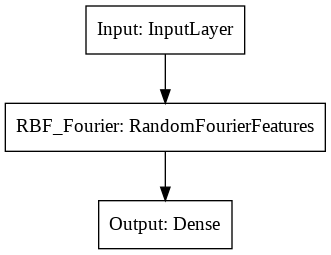

In [9]:
tf.keras.utils.plot_model(model)

In [10]:
model.compile(loss='mse',
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3)) 

In [11]:
history = model.fit(X_train, y_train,
                    epochs=300,
                    batch_size=64, 
                    validation_data=(X_valid, y_valid))

Epoch 1/300
88/88 [==============================] - 2s 6ms/step - loss: 0.1897 - val_loss: 0.0859
Epoch 2/300
88/88 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0583
Epoch 3/300
88/88 [==============================] - 0s 2ms/step - loss: 0.0542 - val_loss: 0.0487
Epoch 4/300
88/88 [==============================] - 0s 2ms/step - loss: 0.0473 - val_loss: 0.0442
Epoch 5/300
88/88 [==============================] - 0s 4ms/step - loss: 0.0434 - val_loss: 0.0421
Epoch 6/300
88/88 [==============================] - 0s 2ms/step - loss: 0.0410 - val_loss: 0.0410
Epoch 7/300
88/88 [==============================] - 0s 2ms/step - loss: 0.0404 - val_loss: 0.0402
Epoch 8/300
88/88 [==============================] - 0s 2ms/step - loss: 0.0399 - val_loss: 0.0398
Epoch 9/300
88/88 [==============================] - 0s 2ms/step - loss: 0.0394 - val_loss: 0.0392
Epoch 10/300
88/88 [==============================] - 0s 2ms/step - loss: 0.0386 - val_loss: 0.0388
Epoch 11/

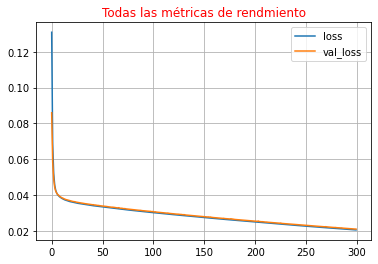

In [12]:
hpd = pd.DataFrame(history.history)

hpd.plot()
plt.title('Todas las métricas de rendmiento', c='r')
plt.grid(True)
plt.show()

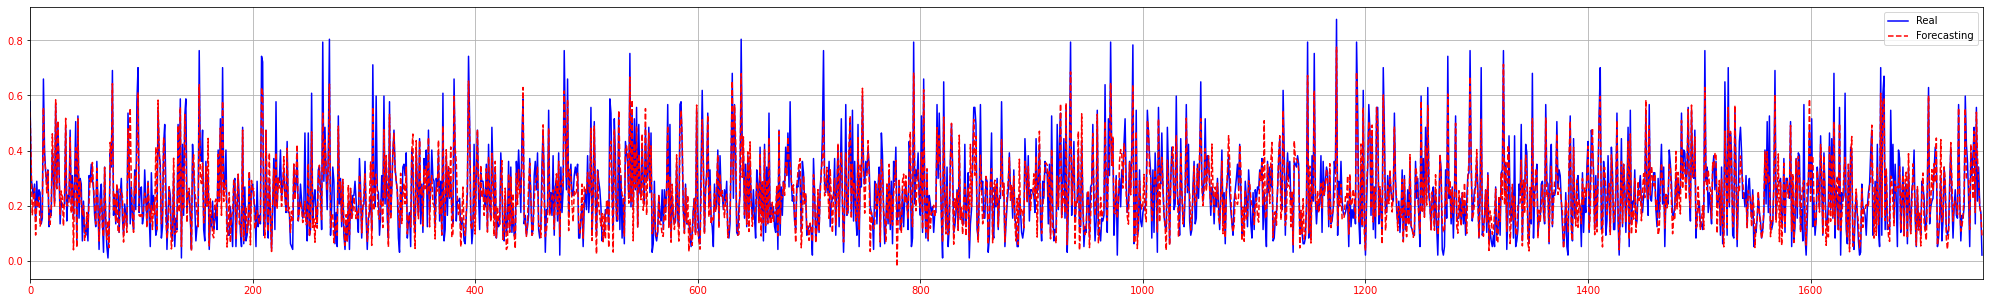

In [13]:
forecasting = model.predict(X_test)
plt.figure(figsize=(35,5))
plt.plot(y_test, c='b', label='Real')
plt.plot(forecasting, c='r', label='Forecasting', linestyle='--')
plt.xlim(0,len(y_test))
plt.xticks(c='r')
plt.yticks(c='r')
plt.grid(True)
plt.legend()
plt.show()